# Telecomunnications Churn dataset
## Part 1 - data visualisation and processing
This notebook explores a customer churn dataset for a telecommunications service. It includes an exploratory data analysis, then proccesses the data to be used for churn prediction modelling. 
There are two resulting datasets a) data_cleaned.csv, and b) data_processed.csv.

Contents:
1. Summaries of the dataset, 
2. Exploratory Data Analysis - investigation of interesing features
2. Data processing for ML - decision tree, random forest, ensemble learning
3. Appendix - further EDA and visualisation

An updated dataset with further information can be found here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
BASE_DIR = os.path.dirname(os.path.abspath('')) # define base directory
DATA_DIR = os.path.join(BASE_DIR, 'Data')
OUT_DIR = os.path.join(BASE_DIR, 'Output')

## 1. Import, Summary and Descriptive Statistics

In [8]:
data = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))

# Check data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,No
2,0004-TLHLJ,Male,1,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,Yes


In [3]:
data.info()
# data.isnull().any() # returns boolean if any columns contain null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


There are 7032 rows, 20 columns, and no NaN entries

In [4]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.286832,32.421786,64.798208,2283.300441
std,0.452314,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,1.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [9]:
# Drop any irrelevant columns (Cusotmer ID)
data.drop('customerID', axis=1, inplace=True)

## 2. Exploratory Data Analysis

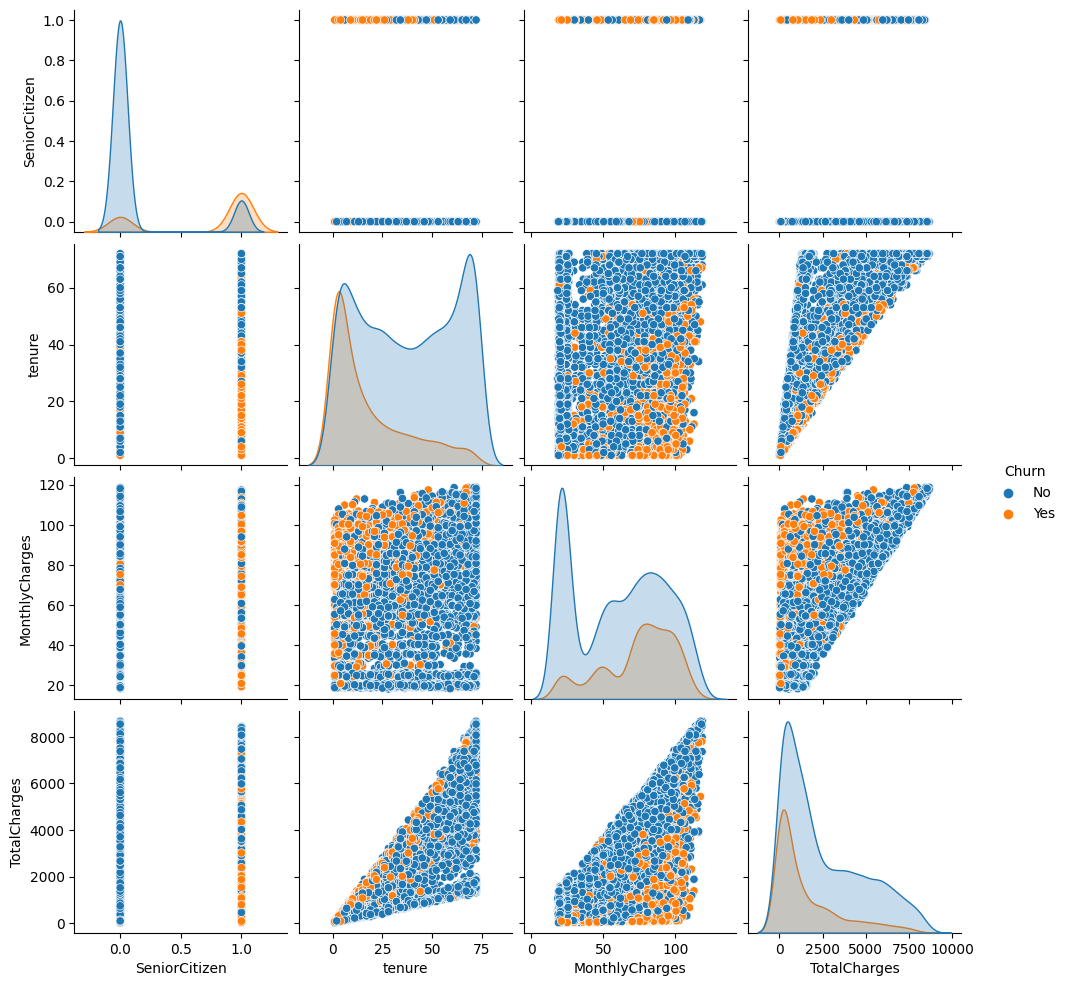

In [5]:
# Inital pairplot - Note that this only shows the features with numerical data
sns.pairplot(data, hue='Churn');

### Observations from pairplot
- A lot of people who churned were senior citizens
- Senior citizens had lower tenure
- Senior citizens had lower TotalCharges (because of lower tenure and higher churn)
- Little to no linear correlation with many of the features (MonthlyCharges vs TotalCharges, tenure vs MonthlyCharges etc.)

### Examine churn distribution and senior citizens

In [11]:
data['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

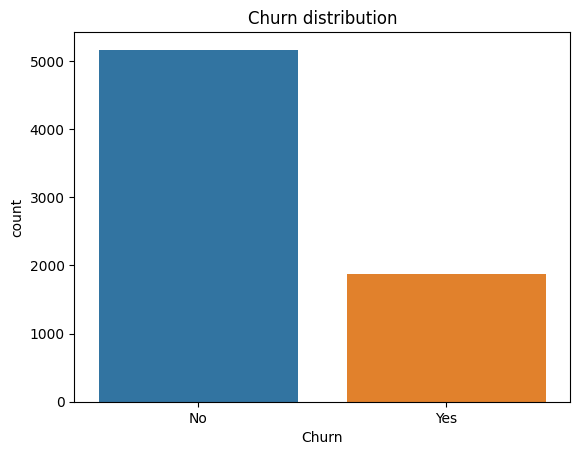

In [12]:
plt.title("Churn distribution")
sns.countplot(data=data, x="Churn");

In [13]:
churn_0 = data['Churn'].value_counts()[0]
churn_1 = data['Churn'].value_counts()[1]
print(f"Percentage of churn No = {round( churn_0/(churn_0 + churn_1)*100 , 2)}%")
print(f"Percentage of churn Yes = {round( churn_1/(churn_0 + churn_1)*100 ,2)}%")

Percentage of churn No = 73.42%
Percentage of churn Yes = 26.58%


The above cells show a class imbalance of approximately 2.8:1 (No to Yes). This ratio does not signify a severe imbalance so we can proceed with leaving the data as is. Further investigation into this could be possible when making predictive models.

In [14]:
data['SeniorCitizen'].value_counts()

0    5015
1    2017
Name: SeniorCitizen, dtype: int64

There are 2017 SeniorCitizens in a dataset of 7032 (~29%)

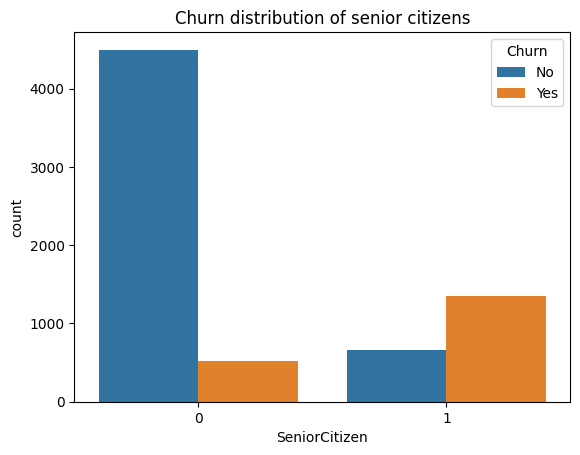

In [40]:
plt.title("Churn distribution of senior citizens")
sns.countplot(data=data, x='SeniorCitizen', hue='Churn');


In [38]:
ss_churn_no = len(data[(data["Churn"] == "Yes") & (data["SeniorCitizen"]==0)])
ss_churn_yes = len(data[(data["Churn"] == "Yes") & (data["SeniorCitizen"]==1)])

print(f"The number of senior citizens who left are: {ss_churn_yes}")
print(f"The number of senior citizens who stayed are: {ss_churn_no}")

The number of senior citizens who left are: 1351
The number of senior citizens who stayed are: 518


### 2.1 Additional look at other features

Investigate MonthlyCost to customer churn. Are churning customers paying higher prices?

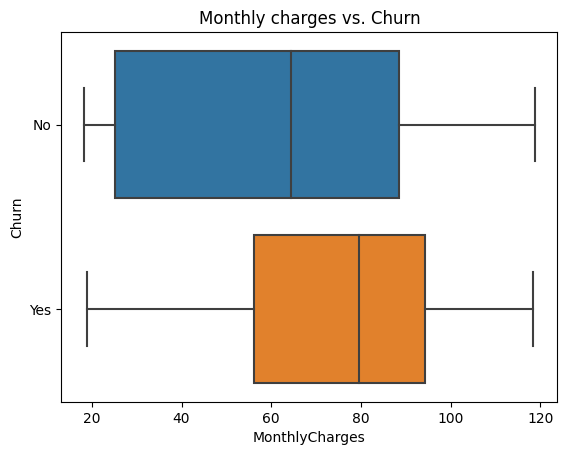

In [41]:
plt.title("Monthly charges vs. Churn")
sns.boxplot(data=data, x="MonthlyCharges", y="Churn");

In [54]:
# Display Q1, Q2 and Q3 for the graph above
data['MonthlyCharges'][data["Churn"] == "Yes"].quantile([0.25, 0.5, 0.75])
#data['MonthlyCharges'][data["Churn"] == "No"].quantile([0.25, 0.5, 0.75])

0.25    56.15
0.50    79.65
0.75    94.20
Name: MonthlyCharges, dtype: float64

How about tenure? Is there a relationship between churn and tenure (how long a customer stays)?

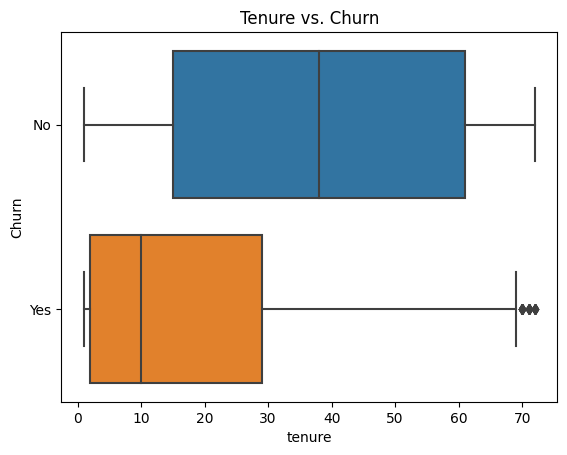

In [42]:
plt.title("Tenure vs. Churn")
sns.boxplot(data=data, x="tenure", y="Churn");

What type of contracts are churning customers on?

In [57]:
data['Contract'][data['Churn']=="Yes"].value_counts()

Month-to-month    1655
One year           166
Two year            48
Name: Contract, dtype: int64

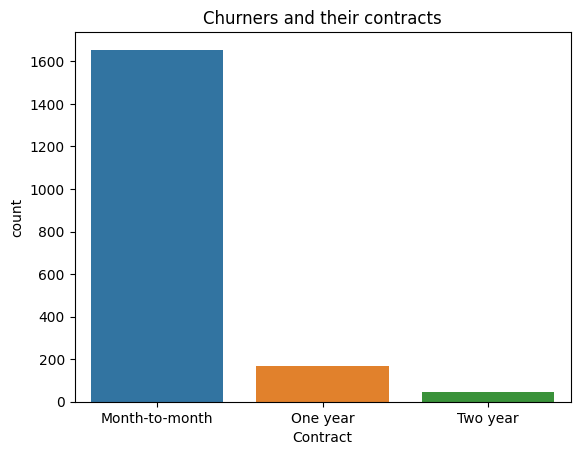

In [16]:
plt.title('Churners and their contracts')
sns.countplot(data=data, x=data['Contract'][data['Churn']=="Yes"]);

In [17]:
# Export initially cleaned data (no feature encoding)
data.to_csv(os.path.join(DATA_DIR,'data_cleaned.csv'), index=False)

## 3. Processing features for use in ML models
Sklearn requires that categorical variables be numerically encoded. However, that this may not always provide an optimum solution. If a variable has many categories, this can introduce sparsity.

It is not ideal to one-hot encode nominal categorical data.

Continuous variables - Unchanged. Feature scaling of continuous variables are not needed for tree learning.\
Categorical variables - one-hot-encoded\
Target variable (churn) - Churn will be one-hot-encoded

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
#One hot encode 'churn' value as the target (0=No, 1=Yes)
data['Churn']=LabelEncoder().fit_transform(data['Churn'])

In [12]:
# Selects df that contain categorical data
cat_df = data.select_dtypes('object')

In [13]:
# Create new df for preprocessing
data2 = data

In [14]:
# One-hot-encode all categorical columns
data2[cat_df.columns]=data[cat_df.columns].apply(LabelEncoder().fit_transform)

In [15]:
# Final result
data2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,1,9,1,0,0,0,2,0,2,2,0,1,1,3,65.6,593.30,0
1,1,0,0,0,9,1,2,0,0,0,0,0,0,2,0,0,3,59.9,542.40,0
2,1,1,0,0,4,1,0,1,0,0,2,0,0,0,0,1,2,73.9,280.85,1
3,1,1,1,0,13,1,0,1,0,2,2,0,2,2,0,1,2,98.0,1237.85,1
4,0,1,1,0,3,1,0,1,0,0,0,2,2,0,0,1,3,83.9,267.40,1


In [18]:
# Export encoded dataset to csv
data2.to_csv(os.path.join(DATA_DIR,"data_processed.csv"), index=False) 

## 4. Appendix
### 4.1 Pairplot of all data with hue='churn'

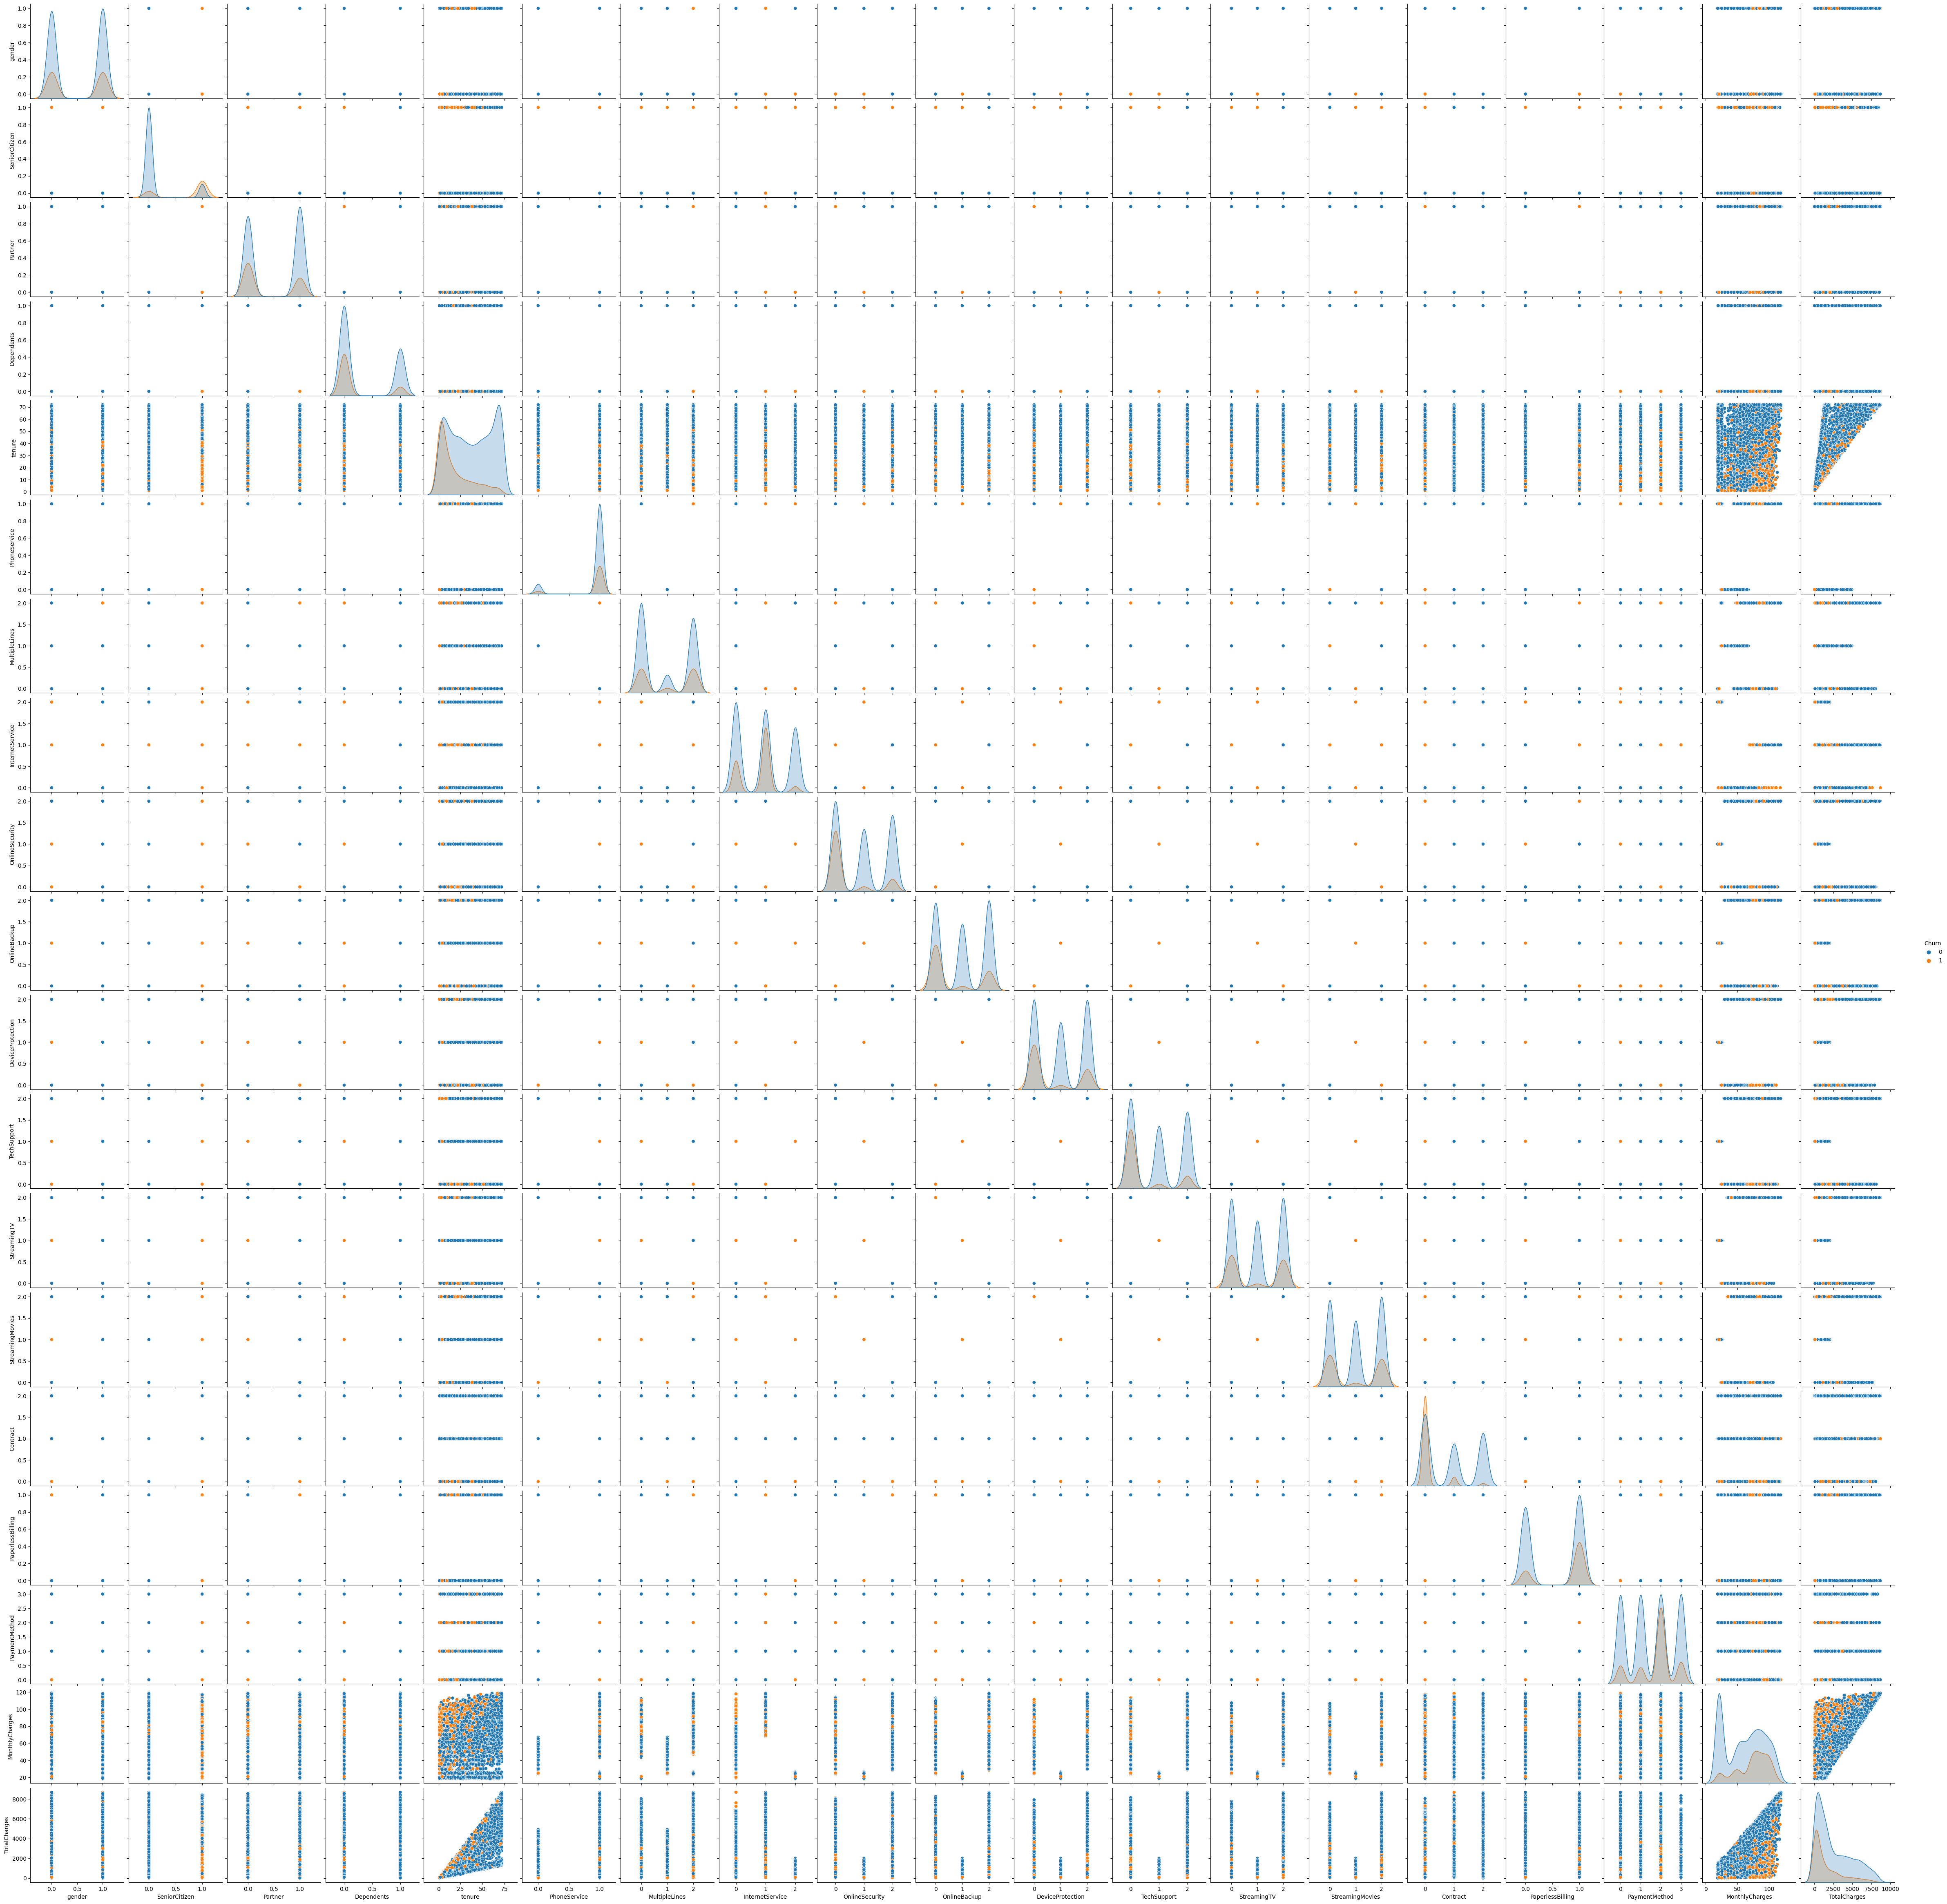

In [30]:
sns.pairplot(data2, hue="Churn")

### 4.2 Count plots of all categorical data seperated by 'Churn'

In [71]:
# List of columns names of categorical columns
col_list = data.select_dtypes('object').columns.to_list()
col_list.remove('Churn')

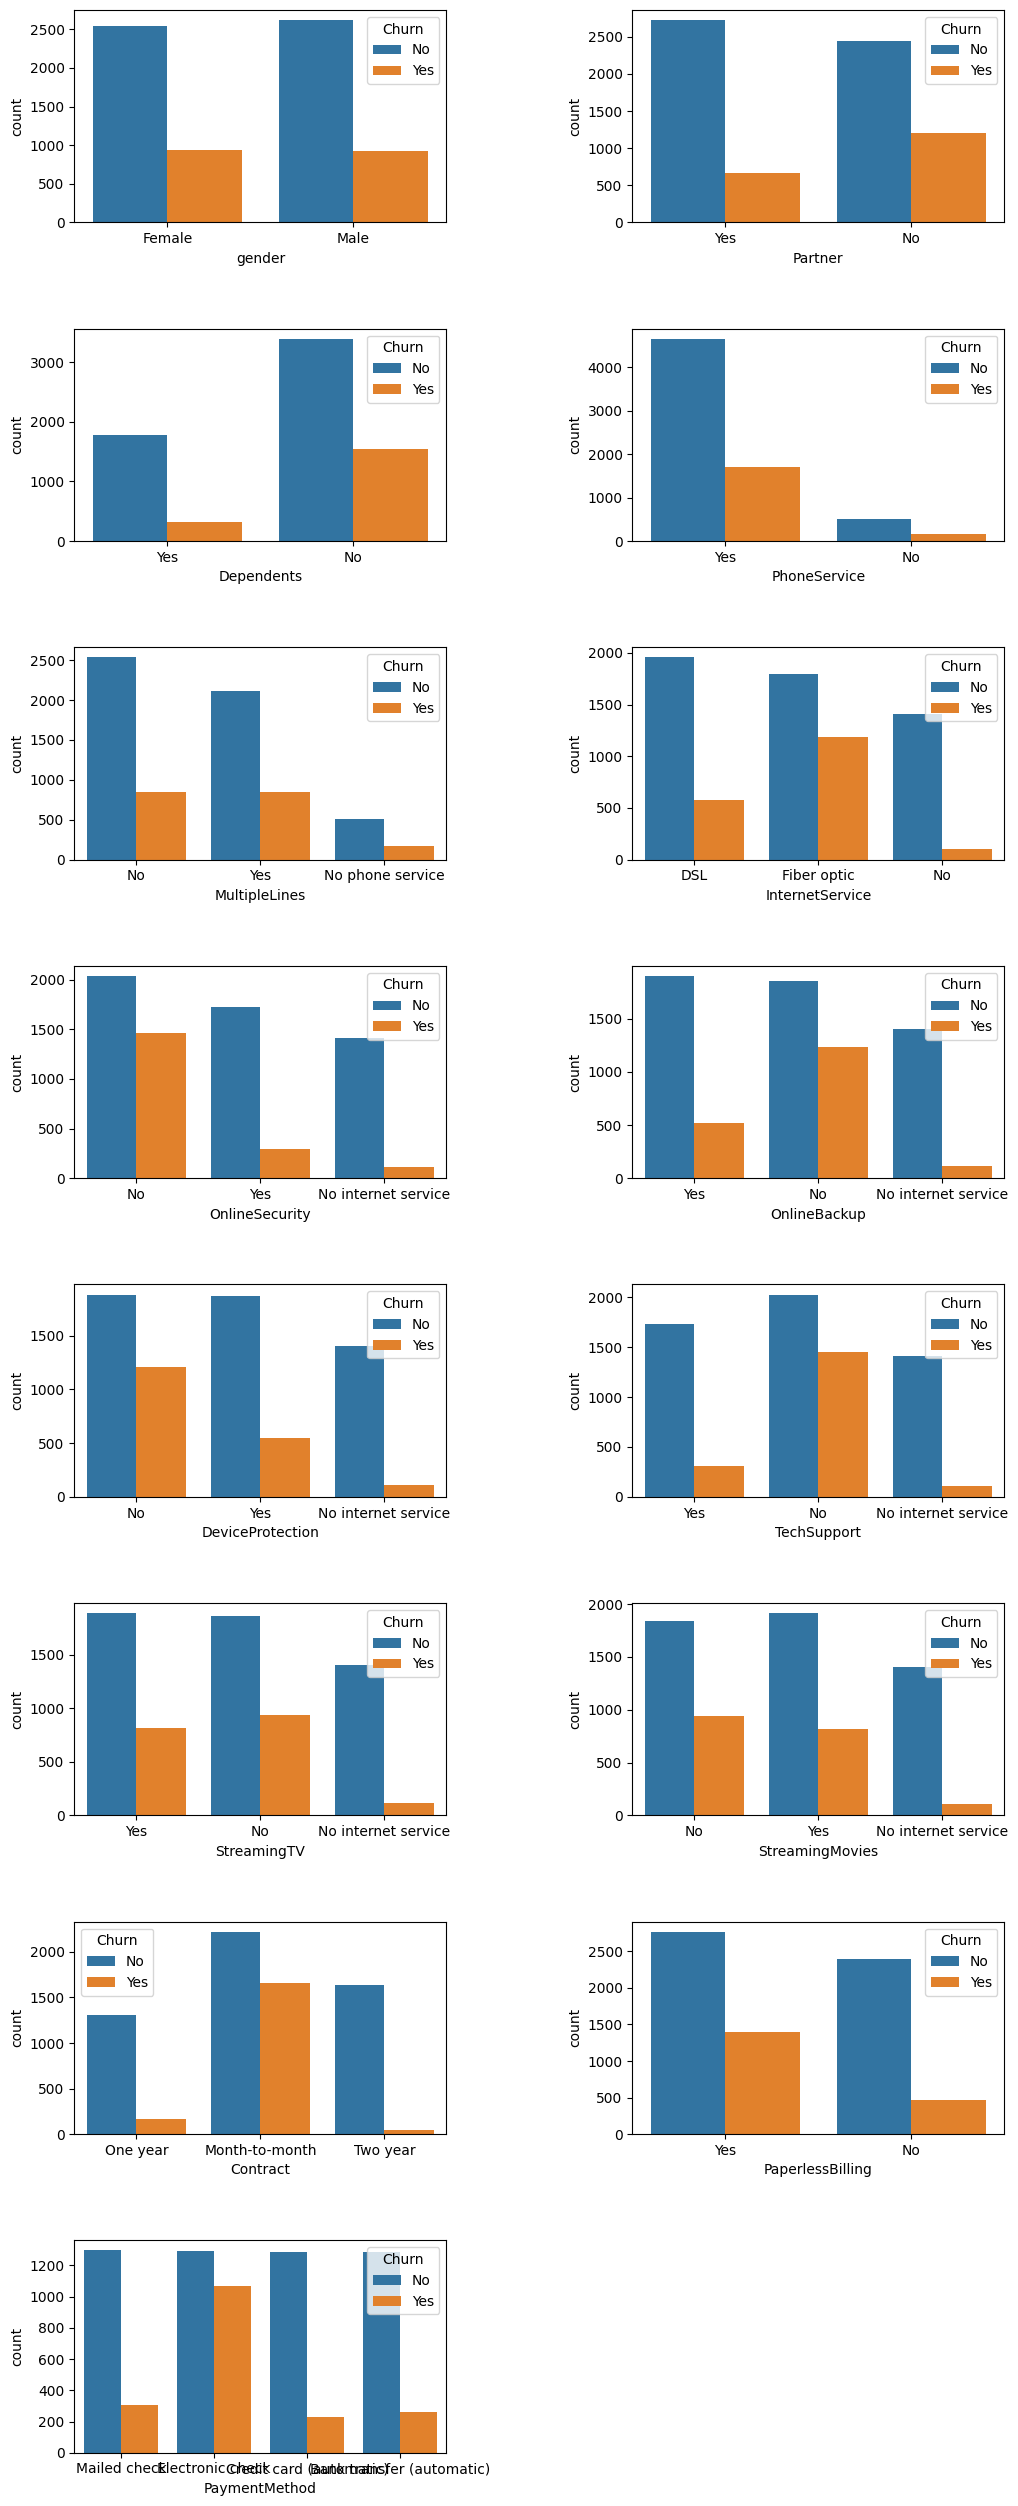

In [73]:
# Use for loop to create all countplots
plt.figure(figsize=(12, 40))
plt.subplots_adjust(hspace=0.5, wspace= 0.5)

for n, item in enumerate(col_list):
    ax=plt.subplot(10, 2, n+1)

    sns.countplot(data=data, x=item, hue='Churn',ax=ax)

##### Observations from count plots
- Most churners have NO dependants, internet security, online backup, device protection and tech support.
- Most churners have phone service, are on Month-to-month contracts and hav electronic credit card as payment methods
- Alot of churners had Fiber optic internet service, more than customers of DSL. Ratio about 2:1

### 4.3 Correlation matrix between all features and 'Churn'

In [26]:
corr_matrix = data2.corr()
corr_matrix["Churn"].sort_values(ascending=False)

Churn               1.000000
SeniorCitizen       0.580023
MonthlyCharges      0.192858
PaperlessBilling    0.191454
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
customerID         -0.017858
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.086618
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64

This shows a moderate positive correlation between SeniorCitizen and Churn
Also shows a small negative correlation between Dependants, DeviceProtection, OnlineBackup, TotalCharges, Techsupport, OnlineSecurity, tenure, contract and churn.